Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

import matplotlib.pyplot as plt
%matplotlib inline

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f, encoding='latin1')
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

---
Logistic Regression with L2 Regularization
---------

In [ ]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():
    tf_train_data = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    
    tf_valid_data = tf.constant(valid_dataset)
    tf_test_data = tf.constant(test_dataset)
    
    beta = tf.placeholder(tf.float32)
    
    #random weights and zeros bias at start
    weights = tf.Variable(tf.truncated_normal([image_size*image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    logits = tf.matmul(tf_train_data, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=logits, labels=tf_train_labels) + beta*(tf.nn.l2_loss(weights)))
    
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    train_preds = tf.nn.softmax(logits)
    valid_preds = tf.nn.softmax(tf.matmul(tf_valid_data, weights) + biases)
    test_preds = tf.nn.softmax(tf.matmul(tf_test_data, weights) + biases)

In [9]:
num_steps = 3001

reg_vals = np.linspace(0.00001, 0.1, 10)
print(reg_vals)
acc_train = []
acc_valid = []
acc_test = []
i=0
for reg in reg_vals:
    i+=1
    print("=============\nprogress: %.1f%%" % (100*i/len(reg_vals)))
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            
            tf_dict = {tf_train_data : batch_data, 
                       tf_train_labels : batch_labels, 
                       beta : reg}
            
            _, l, predictions = session.run([optimizer, loss, train_preds], feed_dict = tf_dict)
            if (step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        acc_valid.append(accuracy(valid_preds.eval(), valid_labels))
        acc_test.append(accuracy(test_preds.eval(), test_labels))



[  1.00000000e-05   1.11200000e-02   2.22300000e-02   3.33400000e-02
   4.44500000e-02   5.55600000e-02   6.66700000e-02   7.77800000e-02
   8.88900000e-02   1.00000000e-01]
progress: 10.0%
Minibatch loss at step 0: 4335.184082
Minibatch accuracy: 3.9%
Minibatch loss at step 500: 36.099014
Minibatch accuracy: 64.8%
Minibatch loss at step 1000: 11.942572
Minibatch accuracy: 66.4%
Minibatch loss at step 1500: 9.199468
Minibatch accuracy: 71.9%
Minibatch loss at step 2000: 10.396114
Minibatch accuracy: 70.3%
Minibatch loss at step 2500: 6.658521
Minibatch accuracy: 60.2%
Minibatch loss at step 3000: 6.670716
Minibatch accuracy: 67.2%
progress: 20.0%
Minibatch loss at step 0: 7710.280762
Minibatch accuracy: 6.2%
Minibatch loss at step 500: 14.357397
Minibatch accuracy: 78.1%
Minibatch loss at step 1000: 1.840452
Minibatch accuracy: 68.0%
Minibatch loss at step 1500: 1.598415
Minibatch accuracy: 69.5%
Minibatch loss at step 2000: 1.874321
Minibatch accuracy: 64.1%
Minibatch loss at step 250

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize = (16,9))
plt.semilogx(reg_vals, acc_valid)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')

fig = plt.figure(figsize = (16,9))
plt.semilogx(reg_vals, acc_test)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')

---
1 Layer NN L2 Regularization
---------

In [13]:
batch_size = 128
num_nodes= 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_data = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_data = tf.constant(valid_dataset)
    tf_test_data = tf.constant(test_dataset)
    
    beta = tf.placeholder(tf.float32)
    
    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_nodes]))
    biases1 = tf.Variable(tf.zeros([num_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    layer1 = tf.nn.relu(tf.matmul(tf_train_data, weights1) + biases1)
    logit2 = tf.matmul(layer1, weights2) + biases2
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logit2)
        + beta*(tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2)))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_preds = tf.nn.softmax(logit2)
    
    layer1 = tf.nn.relu(tf.matmul(tf_test_data, weights1) + biases1)
    test_preds = tf.nn.softmax(tf.matmul(layer1, weights2) + biases2)
    
    layer1 = tf.nn.relu(tf.matmul(tf_valid_data, weights1) + biases1)
    valid_preds = tf.nn.softmax(tf.matmul(layer1, weights2) + biases2)

In [14]:
num_steps = 3001

reg_vals = np.linspace(0.00001, 0.1, 10)
print(reg_vals)
acc_train = []
acc_valid = []
acc_test = []
i=0
for reg in reg_vals:
    i+=1
    print("=============\nprogress: %.1f%%" % (100*i/len(reg_vals)))
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            
            tf_dict = {tf_train_data : batch_data, 
                       tf_train_labels : batch_labels, 
                       beta : reg}
            
            _, l, predictions = session.run(
                [optimizer, loss, train_preds], feed_dict = tf_dict)
            
            if (step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
        acc_valid.append(accuracy(valid_preds.eval(), valid_labels))
        acc_test.append(accuracy(test_preds.eval(), test_labels))



[  1.00000000e-05   1.11200000e-02   2.22300000e-02   3.33400000e-02
   4.44500000e-02   5.55600000e-02   6.66700000e-02   7.77800000e-02
   8.88900000e-02   1.00000000e-01]
progress: 10.0%
Minibatch loss at step 0: 4320.321289
Minibatch accuracy: 11.7%
Minibatch loss at step 500: 29.803169
Minibatch accuracy: 58.6%
Minibatch loss at step 1000: 11.051771
Minibatch accuracy: 66.4%
Minibatch loss at step 1500: 11.007452
Minibatch accuracy: 68.8%
Minibatch loss at step 2000: 9.363455
Minibatch accuracy: 71.1%
Minibatch loss at step 2500: 6.738040
Minibatch accuracy: 61.7%
Minibatch loss at step 3000: 6.948409
Minibatch accuracy: 67.2%
progress: 20.0%
Minibatch loss at step 0: 7828.930176
Minibatch accuracy: 7.8%
Minibatch loss at step 500: 14.383654
Minibatch accuracy: 77.3%
Minibatch loss at step 1000: 1.782471
Minibatch accuracy: 71.1%
Minibatch loss at step 1500: 1.599851
Minibatch accuracy: 69.5%
Minibatch loss at step 2000: 1.874439
Minibatch accuracy: 64.1%
Minibatch loss at step 25

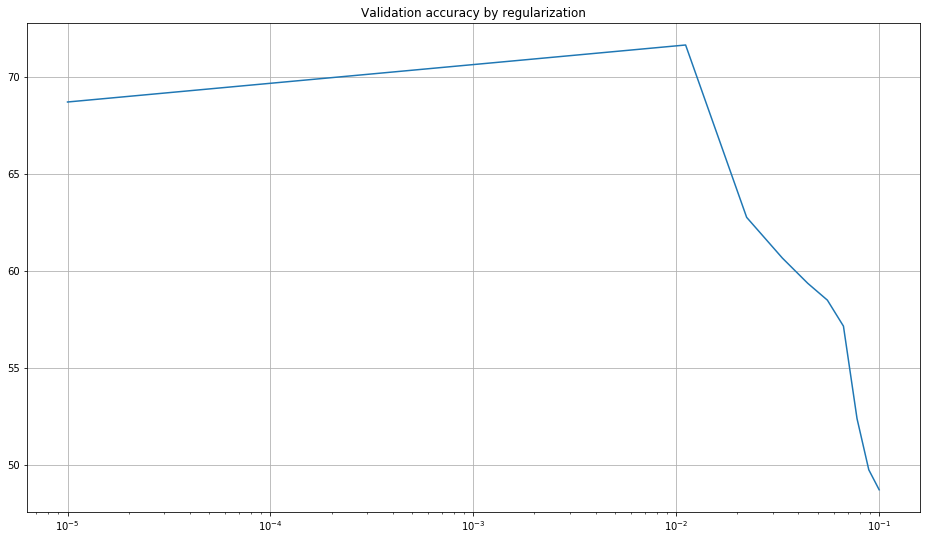

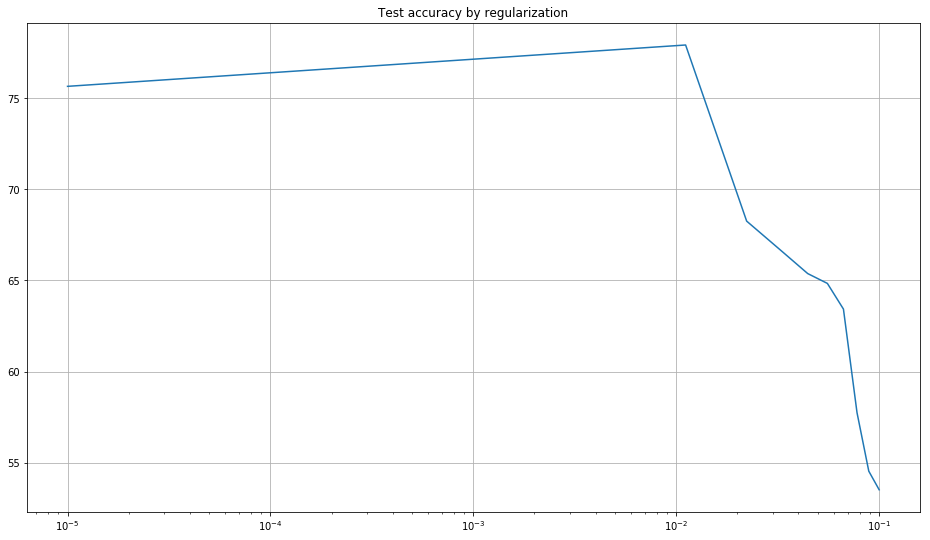

In [15]:
fig = plt.figure(figsize = (16,9))
plt.semilogx(reg_vals, acc_valid)
plt.grid(True)
plt.title('Validation accuracy by regularization')

fig = plt.figure(figsize = (16,9))
plt.semilogx(reg_vals, acc_test)
plt.grid(True)
plt.title('Test accuracy by regularization')

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [22]:
batch_size = 128
num_nodes= 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_data = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_data = tf.constant(valid_dataset)
    tf_test_data = tf.constant(test_dataset)
    
    beta = tf.placeholder(tf.float32)
    
    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_nodes]))
    biases1 = tf.Variable(tf.zeros([num_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    layer1 = tf.nn.relu(tf.matmul(tf_train_data, weights1) + biases1)
    logit2 = tf.matmul(layer1, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        labels=tf_train_labels, logits=logit2))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_preds = tf.nn.softmax(logit2)
    
    layer1_test = tf.nn.relu(tf.matmul(tf_test_data, weights1) + biases1)
    test_preds = tf.nn.softmax(tf.matmul(layer1_test, weights2) + biases2)
    
    layer1_valid = tf.nn.relu(tf.matmul(tf_valid_data, weights1) + biases1)
    valid_preds = tf.nn.softmax(tf.matmul(layer1_valid, weights2) + biases2)

In [23]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
        offset = ((step % num_batches) * batch_size) % (train_labels.shape[0] - batch_size)
        
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        tf_dict = {tf_train_data : batch_data, 
                   tf_train_labels : batch_labels, 
                   beta : 1e-3}
        
        _, l, predictions = session.run(
            [optimizer, loss, train_preds], feed_dict = tf_dict)
        
        if (step % 10 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            


Minibatch loss at step 0: 298.798309
Minibatch accuracy: 7.8%
Minibatch loss at step 10: 26.500786
Minibatch accuracy: 90.6%
Minibatch loss at step 20: 0.000008
Minibatch accuracy: 100.0%
Minibatch loss at step 30: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 40: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 50: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 60: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 70: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 80: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 90: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 100: 0.000000
Minibatch accuracy: 100.0%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [25]:
batch_size = 128
num_nodes= 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_data = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_data = tf.constant(valid_dataset)
    tf_test_data = tf.constant(test_dataset)
    
    beta = tf.placeholder(tf.float32)
    
    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_nodes]))
    biases1 = tf.Variable(tf.zeros([num_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    layer1 = tf.nn.relu(tf.matmul(tf_train_data, weights1) + biases1)
    drop_layer1 = tf.nn.dropout(layer1, 0.5)
    logit2 = tf.matmul(drop_layer1, weights2) + biases2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        labels=tf_train_labels, logits=logit2))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_preds = tf.nn.softmax(logit2)
    
    layer1_test = tf.nn.relu(tf.matmul(tf_test_data, weights1) + biases1)
    test_preds = tf.nn.softmax(tf.matmul(layer1_test, weights2) + biases2)
    
    layer1_valid = tf.nn.relu(tf.matmul(tf_valid_data, weights1) + biases1)
    valid_preds = tf.nn.softmax(tf.matmul(layer1_valid, weights2) + biases2)

In [27]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
        offset = (step % 5 )#* batch_size)  % (train_labels.shape[0] - batch_size)
        
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        tf_dict = {tf_train_data : batch_data, 
                   tf_train_labels : batch_labels, 
                   beta : 1e-3}
        
        _, l, predictions = session.run(
            [optimizer, loss, train_preds], feed_dict = tf_dict)
        
        if (step % 100 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            


Minibatch loss at step 0: 467.658264
Minibatch accuracy: 13.3%
Minibatch loss at step 100: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 200: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 300: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 400: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 500: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 600: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 700: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 800: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 900: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 1000: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 1100: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 1200: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 1300: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 1400: 0.000000
Minibatch accuracy: 100.0%
Minibatch loss at step 1500: 0.00000

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


---
Training a Deep Network
---------
Ok So this is the network i talked baout in the meeting.

This network is regularized and uses drops outs. 

The learning rate decays exponentially

Activation retention probability (1-Dropout probability) increases from 0.5  in steps of 0.1

Input layer = image_size * image_size

Layer-1 = 1024 units

Layer-2 = 512 units

Layer-3 = 256 units

output = num_label units


In [12]:
batch_size = 128
input_size = image_size * image_size
num_nodes1 = 1024
num_nodes2 = 512
num_nodes3 = 256
num_nodes4 = 128
beta = 1e-3

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_data = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_data = tf.constant(valid_dataset)
    tf_test_data = tf.constant(test_dataset)
    global_step = tf.Variable(0)
    
    beta = tf.placeholder(tf.float32)
    
    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([input_size, num_nodes1], stddev=np.sqrt(2.0 / input_size)))
    biases1 = tf.Variable(tf.zeros([num_nodes1]))
    
    weights2 = tf.Variable(tf.truncated_normal([num_nodes1, num_nodes2], stddev=np.sqrt(2.0 / num_nodes1)))
    biases2 = tf.Variable(tf.zeros([num_nodes2]))
    
    weights3 = tf.Variable(tf.truncated_normal([num_nodes2, num_nodes3], stddev=np.sqrt(2.0 / num_nodes2)))
    biases3 = tf.Variable(tf.zeros([num_nodes3]))
    
    weights4 = tf.Variable(tf.truncated_normal([num_nodes3, num_nodes4], stddev=np.sqrt(2.0 / num_nodes3)))
    biases4 = tf.Variable(tf.zeros([num_nodes4]))
    
    weights5 = tf.Variable(tf.truncated_normal([num_nodes4, num_labels], stddev=np.sqrt(2.0 / num_nodes4)))
    biases5 = tf.Variable(tf.zeros([num_labels]))
    
    # Training computation.
    layer1 = tf.nn.relu(tf.matmul(tf_train_data, weights1) + biases1)
    drop_layer1 = tf.nn.dropout(layer1, 0.5)
    
    layer2 = tf.nn.relu(tf.matmul(drop_layer1, weights2) + biases2)
    drop_layer2 = tf.nn.dropout(layer2, 0.5)
    
    layer3 = tf.nn.relu(tf.matmul(drop_layer2, weights3) + biases3)
    drop_layer3 = tf.nn.dropout(layer3, 0.5)
    
    layer4 = tf.nn.relu(tf.matmul(drop_layer3, weights4) + biases4)
    drop_layer4 = tf.nn.dropout(layer4, 0.5)
    
    logit5 = tf.matmul(drop_layer4, weights5) + biases5
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logit5) +
                         beta*(tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3) + 
                               tf.nn.l2_loss(weights4) + tf.nn.l2_loss(weights5)))
    
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions for the training, validation, and test data.
    train_preds = tf.nn.softmax(logit5)
    
    layer1_test = tf.nn.relu(tf.matmul(tf_test_data, weights1) + biases1)
    layer2_test = tf.nn.relu(tf.matmul(layer1_test, weights2) + biases2)
    layer3_test = tf.nn.relu(tf.matmul(layer2_test, weights3) + biases3)
    layer4_test = tf.nn.relu(tf.matmul(layer3_test, weights4) + biases4)
    test_preds = tf.nn.softmax(tf.matmul(layer4_test, weights5) + biases5)
    
    layer1_valid = tf.nn.relu(tf.matmul(tf_valid_data, weights1) + biases1)
    layer2_valid = tf.nn.relu(tf.matmul(layer1_valid, weights2) + biases2)
    layer3_valid = tf.nn.relu(tf.matmul(layer2_valid, weights3) + biases3)
    layer4_valid = tf.nn.relu(tf.matmul(layer3_valid, weights4) + biases4)
    valid_preds = tf.nn.softmax(tf.matmul(layer4_valid, weights5) + biases5)

In [14]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
        offset = (step * batch_size)  % (train_labels.shape[0] - batch_size)
        
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        tf_dict = {tf_train_data : batch_data, 
                   tf_train_labels : batch_labels, 
                   beta : 1e-3}
        
        _, l, predictions = session.run(
            [optimizer, loss, train_preds], feed_dict = tf_dict)
        
        if (step % 300 == 0):
            print("=========================================")
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_preds.eval(), valid_labels))
            print("Test accuracy: %.1f%%" % accuracy(test_preds.eval(), test_labels))


Minibatch loss at step 0: 4.137491
Minibatch accuracy: 10.2%
Validation accuracy: 11.3%
Test accuracy: 11.5%
Minibatch loss at step 300: 1.829859
Minibatch accuracy: 78.9%
Validation accuracy: 82.9%
Test accuracy: 90.0%
Minibatch loss at step 600: 1.590990
Minibatch accuracy: 82.0%
Validation accuracy: 84.3%
Test accuracy: 90.8%
Minibatch loss at step 900: 1.367956
Minibatch accuracy: 80.5%
Validation accuracy: 85.2%
Test accuracy: 92.0%
Minibatch loss at step 1200: 1.015932
Minibatch accuracy: 85.9%
Validation accuracy: 85.5%
Test accuracy: 92.0%
Minibatch loss at step 1500: 0.900927
Minibatch accuracy: 88.3%
Validation accuracy: 86.1%
Test accuracy: 92.7%
Minibatch loss at step 1800: 0.966187
Minibatch accuracy: 85.2%
Validation accuracy: 86.4%
Test accuracy: 92.6%
Minibatch loss at step 2100: 0.804079
Minibatch accuracy: 89.1%
Validation accuracy: 87.0%
Test accuracy: 93.1%
Minibatch loss at step 2400: 0.846378
Minibatch accuracy: 83.6%
Validation accuracy: 87.0%
Test accuracy: 93.3